In [16]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EXPERIMENT HELP FUNCTIONS

In [17]:
# Noise distribution parameters, NCE

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y, 0, 1))
    
    return mu, cov

In [18]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n, neg_sample_size)
    
    return criterion.crit(y, 0)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [19]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

In [20]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


In [21]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
y_samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
y_samples_cnce = sample_cnce(y, num_samples, mu, torch.log(torch.tensor(precision)))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\MyPrograms\continuum\Anaconda3\envs\torchenv3\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\amaol67\AppData\Local\Temp\ipykernel_20424\1088410591.py", line 20, in <cell line: 20>
    y_samples_cnce = sample_cnce(y, num_samples, mu, torch.log(torch.tensor(precision)))
  File "C:\Users\amaol67\AppData\Local\Temp\ipykernel_20424\291291928.py", line 18, in sample_cnce
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
  File "C:\Users\amaol67\AppData\Local\Temp\ipykernel_20424\1165650041.py", line 13, in get_cnce_noise_distr_par
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
  File "C:\Users\amaol67\AppData\Local\Temp\ipykernel_20424\1165650041.py", line 42, in get_cnce_epsilon_factor
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)
  File "C:\Users\amaol67\AppD

## EXPERIMENTS

In [9]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 2

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 10

In [10]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n, J)
                
                save_dir = None
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

TypeError: CondNceCrit.crit() missing 1 required positional argument: '_idx'

In [11]:
# Persistent
from src.nce.per_cnce import PersistentCondNceCrit
N, J, rep = 20, 2, 1

# Get data 
mu, precision, _ = generate_true_params()
error_metric = PrecisionErrorMetric(true_precision=precision).metric            

training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                 root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

# Initialise           
_, log_precision_init, log_z_init = initialise_params()

# Get noise distr. params
mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        

p_m = RingModel(mu=mu, log_precision=log_precision_init)

p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)

criterion = CondNceCrit(p_m, p_n, J)

lab = "dump"
save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
err = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                  stopping_condition=no_change_stopping_condition)

TypeError: CondNceCrit.crit() missing 1 required positional argument: '_idx'

In [18]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

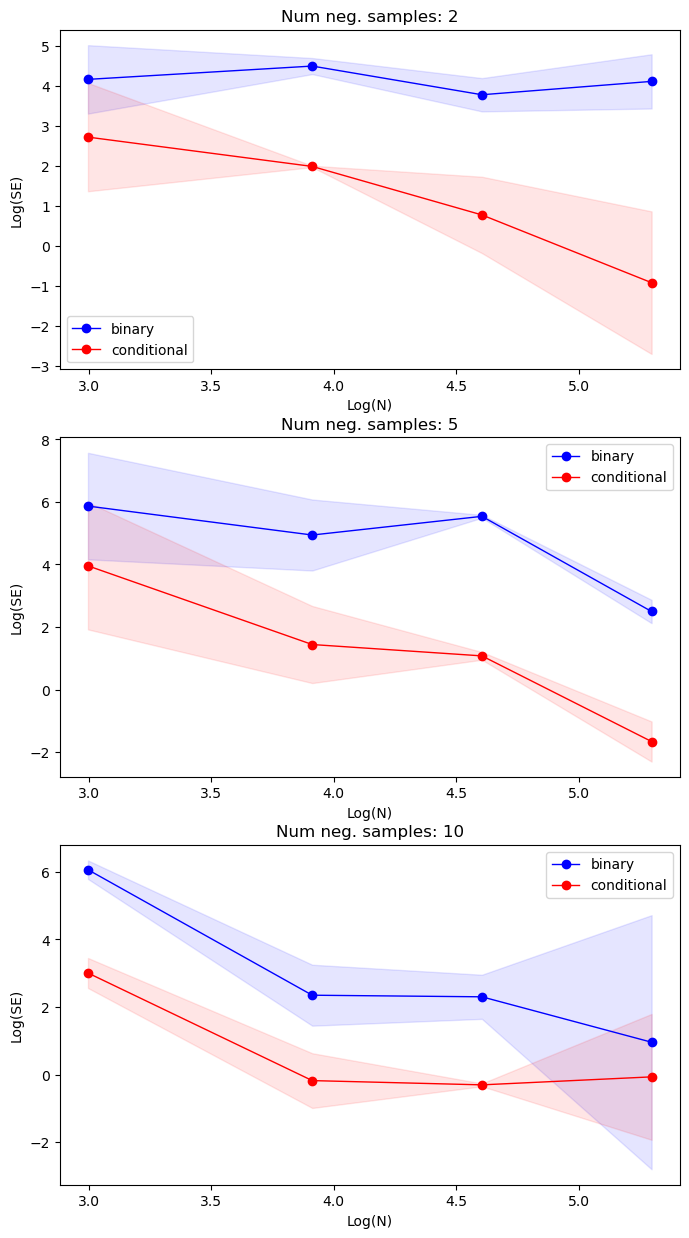

In [19]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()